In [204]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np
import statistics as sts
import math

#read the data
total_cases = pd.read_csv('https://covid.ourworldindata.org/data/total_cases.csv')
total_deaths = pd.read_csv('https://covid.ourworldindata.org/data/total_deaths.csv')
daily_cases = pd.read_csv('https://covid.ourworldindata.org/data/new_cases.csv')
daily_deaths = pd.read_csv('https://covid.ourworldindata.org/data/new_deaths.csv')
full_set = pd.read_csv('https://covid.ourworldindata.org/data/full_data.csv')
amount_of_tests = pd.read_csv('covid-19-tests-country.csv')
tests_per_million = pd.read_csv('covid19-tests-per-million-people.csv')

full_set = full_set.fillna(0)
full_set['date'] = pd.to_datetime(full_set['date'])

#make list of all locations in the data
all_locations = list(set(full_set['location']))
full_set['est_total_cases'] = full_set['total_deaths'] * 100
full_set.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths,est_total_cases
0,2020-02-25,Afghanistan,0.0,0.0,1.0,0.0,0.0
1,2020-02-26,Afghanistan,0.0,0.0,1.0,0.0,0.0
2,2020-02-27,Afghanistan,0.0,0.0,1.0,0.0,0.0
3,2020-02-28,Afghanistan,0.0,0.0,1.0,0.0,0.0
4,2020-02-29,Afghanistan,0.0,0.0,1.0,0.0,0.0


In [205]:
# get all dates since start of incident from anouther datasource
start = datetime.date(2020, 1, 22)     #first known cases on 22-01-2020
today_date = datetime.date.today()
numdays = (today_date - start).days
all_dates = sorted([(today_date - datetime.timedelta(days=x)) for x in range(numdays+1)])
all_dates = [item.__format__('%m-%d-%Y') for item in all_dates]


#read the data

url_base = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'

date_dict = {}
for date in all_dates[:-1]:
    date_dict[date] = {}
    url = url_base + date + '.csv'
    df = pd.read_csv(url)
    df = df.fillna(0)
    available_countries = set(df['Country/Region'])
    for item in available_countries:
        date_dict[date][item] = {'infected': sum((df.loc[df['Country/Region'] == item]['Confirmed']).values),
                            'deaths': sum((df.loc[df['Country/Region'] == item]['Deaths']).values),
                            'recovered': sum((df.loc[df['Country/Region'] == item]['Recovered']).values),
                           }
df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-16T14:38:45,67798,3099,55142,30.9756,112.2707
1,0,Italy,2020-03-16T17:33:03,27980,2158,2749,41.8719,12.5674
2,0,Iran,2020-03-16T14:38:45,14991,853,4590,32.4279,53.6880
3,0,Spain,2020-03-16T20:13:11,9942,342,530,40.4637,-3.7492
4,0,"Korea, South",2020-03-16T14:38:45,8236,75,1137,35.9078,127.7669


In [206]:
### Functions used

## Function to add the growth_rate for a given city
def growt_rate(dataframe, city):
    '''Function to build dataframe for a given city, adding growth rate'''
    # Add a growth rate for a country
    df_GR = dataframe.loc[dataframe['location']== city]
    df_GR = df_GR.loc[df_GR['total_cases'] >= 5]
    df_GR = df_GR.reset_index()

    # calculate GR
    SK_GR =[0.0] + [(df_GR['new_cases'][i+1] /df_GR['new_cases'][i]) for i in range(len(df_GR)-1)]
    df_GR['GR'] = SK_GR

    #replace inf and NaN with 0
    df_GR = df_GR.replace([np.inf, -np.inf], np.nan)
    df_GR = df_GR.replace(np.NaN,0)
    return df_GR

def growt_rate2(dataframe, city):
    '''Function to build dataframe for a given city, adding growth rate'''
    # Add a growth rate for a country
    df_GR = dataframe.loc[dataframe['location']== city]
    df_GR = df_GR.loc[df_GR['total_cases'] >= 5]
    df_GR = df_GR.reset_index()

    # calculate GR
    #SK_GR =[0.0] + [(df_GR['new_cases'][i+1] /df_GR['new_cases'][i]) for i in range(len(df_GR)-1)]
    df_GR['GR'] = df_GR['new_cases'] / df_GR['total_cases']

    #replace inf and NaN with 0
    df_GR = df_GR.replace([np.inf, -np.inf], np.nan)
    df_GR = df_GR.replace(np.NaN,0)
    return df_GR

#test function
#df_growthrate = growt_rate(full_set, 'Netherlands' )
#df_growthrate.head()

## Function to plot total cases
def plot_total_cases(country_list, title, height = 15):
    """Function to plot the given countries total cases over time, takes an list of countries as input"""
    plt.figure(figsize=(20,height))
    for item in country_list:
        x = full_set.loc[full_set['location']== item]['date']
        y = full_set.loc[full_set['location']== item]['total_cases']
        y1 = full_set.loc[full_set['location']== item]['est_total_cases']
        plt.plot(x,y, label='reported cases: {}'.format(item))
        plt.plot(x,y1, label='estimated cases: {}'.format(item))

    plt.ylabel("Amount of infections")
    plt.xlabel('Date range')
    plt.title(title)
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()
    
#test_list = ['Netherlands', 'Italy']
#plot_total_cases(test_list, 'total cases for italy vs nl')

## Function to plot new cases
def plot_new_cases(country_list, title, start = 0, height=10, width=20):
    """Function to plot the given countries total cases over time, takes an list of countries as input"""
    plt.figure(figsize=(width,height))
    for item in country_list:
        x = full_set.loc[full_set['location']== item]['date'][start:]
        y = full_set.loc[full_set['location']== item]['new_cases'][start:]
        plt.plot(x,y, label=item)

    plt.ylabel("Amount of new cases")
    plt.xlabel('Date range')
    plt.title(title)
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

#Function to plot deaths per country
def plot_death_cases(country_list, title, start = 0, height=10, width=20):
    """Function to plot the given countries total cases over time, takes an list of countries as input"""
    plt.figure(figsize=(width,height))
    for item in country_list:
        x = full_set.loc[full_set['location']== item]['date'][start:]
        y = full_set.loc[full_set['location']== item]['total_deaths'][start:]
        plt.plot(x,y, label=item)

    plt.ylabel("Amount of deaths")
    plt.xlabel('Date range')
    plt.title(title)
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

def death_rate(dataframe, city):
    '''Function to build dataframe for a given city, adding growth rate'''
    # Add a growth rate for a country
    df_dr = dataframe.loc[dataframe['location']== city]
    #df_dr = df_GR.loc[df_GR['total_cases'] >= 5]
    df_dr = df_dr.reset_index()

    # calculate DR
    deathrate = [(df_dr['total_deaths'][i] /df_dr['total_cases'][i]) for i in range(len(df_dr))]
    df_dr['DR'] = deathrate

    #replace inf and NaN with 0
    #df_GR = df_GR.replace([np.inf, -np.inf], np.nan)
    #df_GR = df_GR.replace(np.NaN,0)
    df_dr = df_dr.loc[df_dr['DR'] < 1]
    return df_dr

#test_list = ['Netherlands', 'Italy']
#plot_new_cases(test_list, 'new cases over time for NL and IT')
#death_rate(full_set, 'Netherlands').head()


# Return a dataFrame for a given country
def dataframe_from_dict(country):
    pre_df = []
    for date in all_dates:
        try:
            pre_df.append([date, country, 
                           date_dict[date][country]['infected'], 
                            date_dict[date][country]['deaths'], 
                             date_dict[date][country]['recovered']])
        except:
            pass
    country_df = pd.DataFrame(pre_df, columns=['date','country', 'infected', 'deaths', 'recovered'])
    country_df['delta_recover'] = [0]+[country_df['recovered'][x+1] - country_df['recovered'][x] for x in range(len(country_df['recovered'])-1)]
    return country_df

#test the function
dataframe_from_dict('Italy').head()

,date,country,infected,deaths,recovered,delta_recover
0,01-31-2020,Italy,2,0.0,0.0,0.0
1,02-01-2020,Italy,2,0.0,0.0,0.0
2,02-02-2020,Italy,2,0.0,0.0,0.0
3,02-03-2020,Italy,2,0.0,0.0,0.0
4,02-04-2020,Italy,2,0.0,0.0,0.0


# Calculate Growth Rate
The growth rate for countries with more then 50 cases is calculated. We start looking from a moment when there are more then 5 cases know in a country.

In [213]:
# Make a list with cities with more total_cases then threshold
threshold = 50
more_then = full_set.loc[full_set['date']== '2020-03-16']
more_then = more_then.loc[full_set['total_cases'] >= threshold]
more_then_c_list = list(more_then['location'])
more_then_c_list.remove('International')
more_then_c_list.remove('World')

#Calculate the growth_rates, build a model
growth_rates = []
for country in more_then_c_list:
    # Add a growth rate for a country
    
    
    growth_rates.append([country, growt_rate2(full_set, country)['GR'].mean()])
    
df = pd.DataFrame.from_records(growth_rates)
df = df.dropna()
df.to_csv('test.csv')   #write to csv for further processing of the visualization.
df = df.sort_values(1)

C:\Users\_Vinc\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

divide by zero encountered in double_scalars



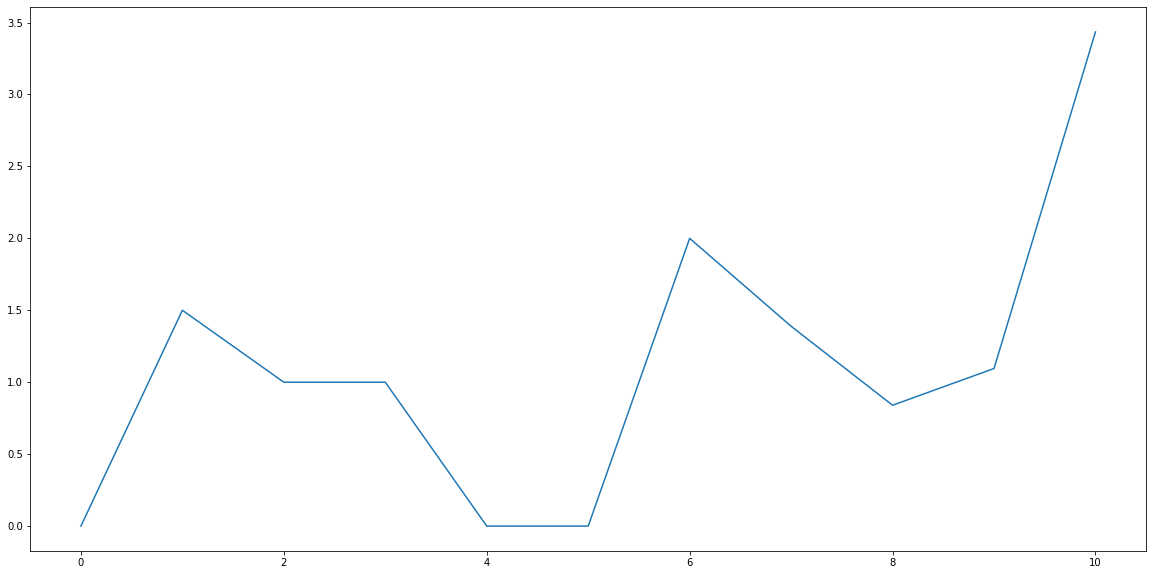

In [208]:
Growth_rate_plt = growt_rate(full_set, 'Brazil')['GR']
plt.figure(figsize=(20,10))
plt.plot(Growth_rate_plt)
plt.show()

In [214]:
df

,0,1
52,Thailand,0.053395
56,Vietnam,0.061744
54,United Arab Emirates,0.063473
45,Singapore,0.075921
1,Australia,0.079230
30,Malaysia,0.087086
10,China,0.087256
8,Canada,0.092884
27,Japan,0.099282
55,United States,0.106660


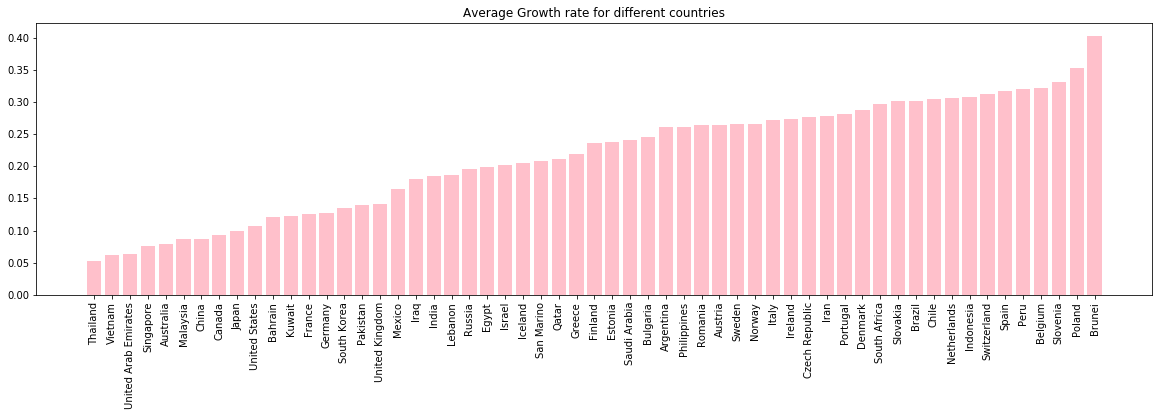

In [221]:
# Plot a bar-chart with growth-rate
plt.figure(figsize=(20,5))
plt.bar(df[0], df[1], width=0.8, color='pink')

plt.title('Average Growth rate for different countries')
plt.xticks(rotation = 90)
plt.show()

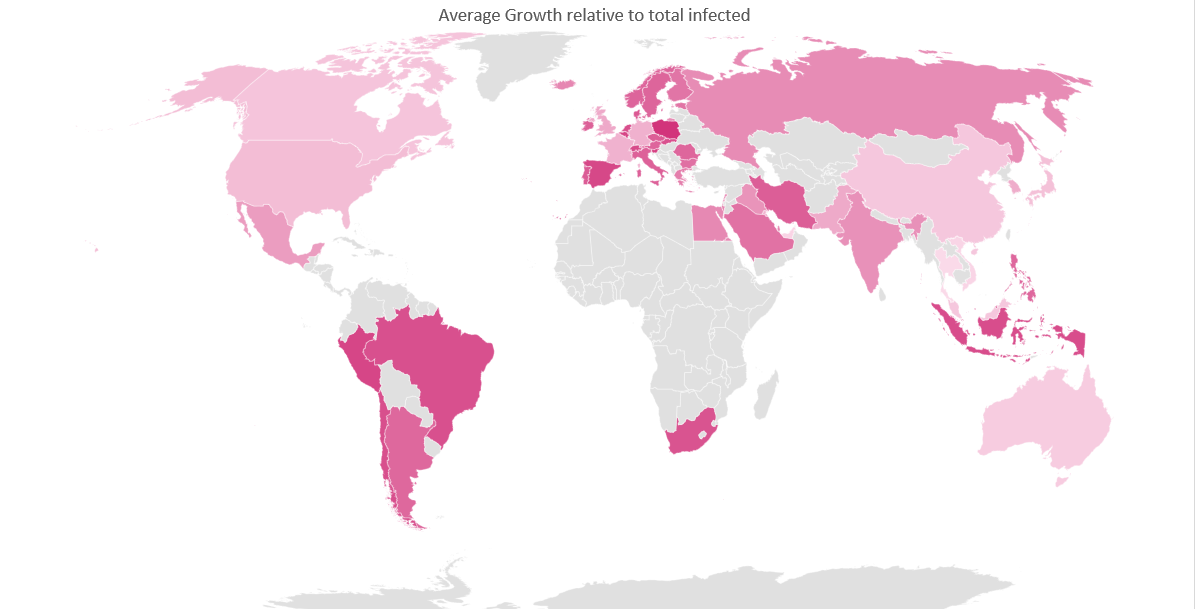

C:\Users\_Vinc\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

divide by zero encountered in double_scalars



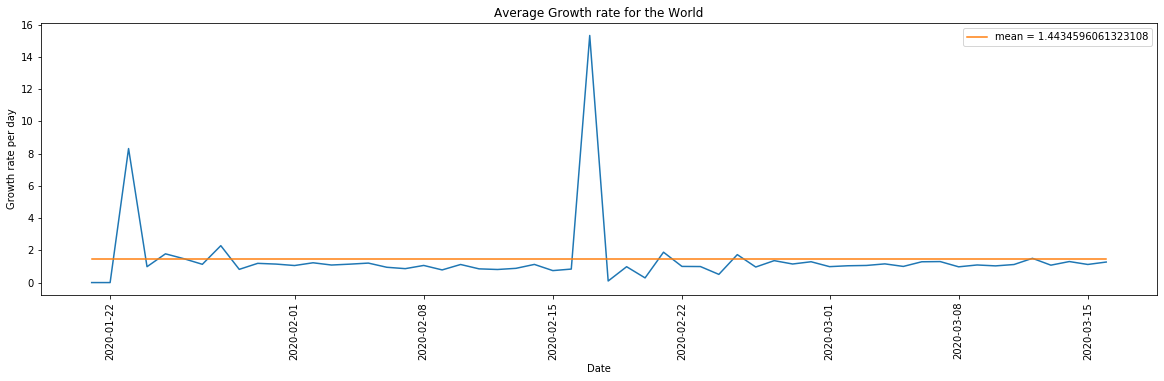

In [99]:
# plot the development of the growtrate for the world:

plt.figure(figsize=(20,5))
plt.plot(growt_rate(full_set, 'World')['date'], growt_rate(full_set, 'World')['GR'])
ymean = [growt_rate(full_set, 'World')['GR'].mean() for date in range(len(growt_rate(full_set, 'World')['date']))]
plt.plot(growt_rate(full_set, 'World')['date'], ymean, label='mean = {}'.format(ymean[0]))

plt.ylabel("Growth rate per day")
plt.xlabel('Date')
plt.title('Average Growth rate for the World')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

C:\Users\_Vinc\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

divide by zero encountered in double_scalars



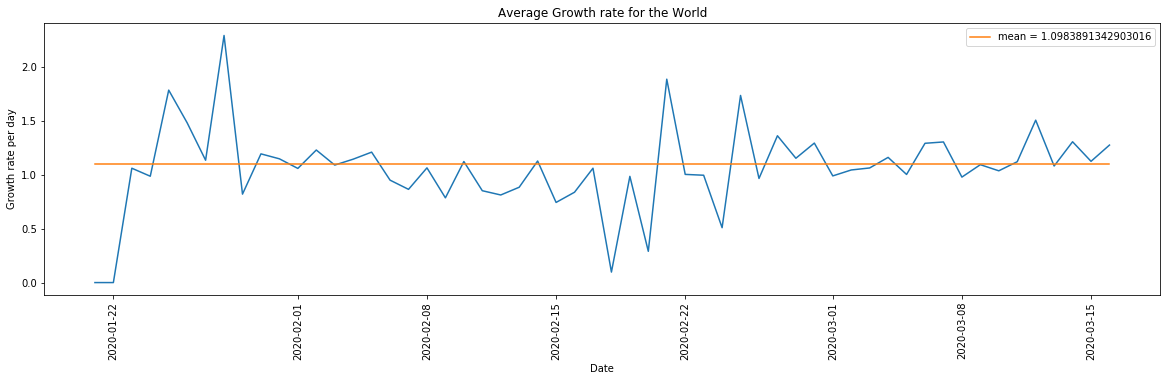

In [100]:
# Now without the exponential growth outliers (x8 in the beginning, x15 when spread to the rest of the world)
growt_rate(full_set, 'World')

plt.figure(figsize=(20,5))
ygr = [x if x < 4 else sts.mean([x for x in growt_rate(full_set, 'World')['GR'] if x <4]) for x in growt_rate(full_set, 'World')['GR']]
plt.plot(growt_rate(full_set, 'World')['date'], ygr)
ymean = [sts.mean(ygr[2:]) for date in range(len(growt_rate(full_set, 'World')['date']))]
plt.plot(growt_rate(full_set, 'World')['date'], ymean, label='mean = {}'.format(ymean[0]))

plt.ylabel("Growth rate per day")
plt.xlabel('Date')
plt.title('Average Growth rate for the World')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

# Plot the total cases in the world
We plot the cases that have more then 50 infections in total

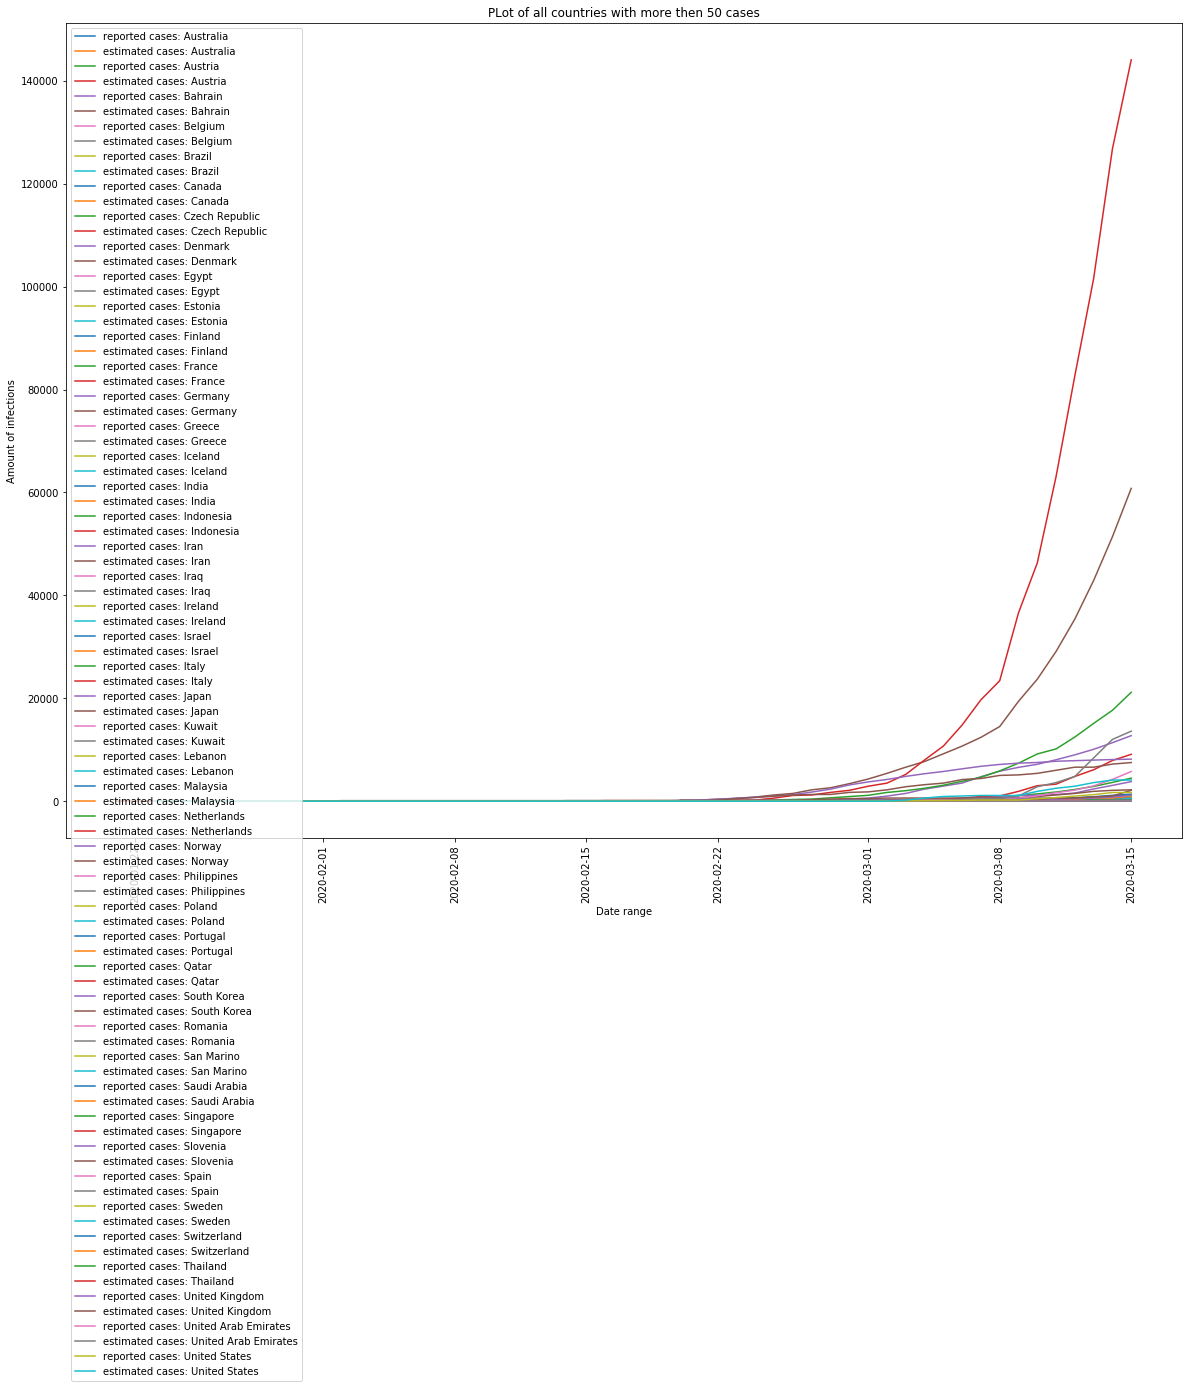

In [9]:
# plot dutch cases against Italian cases
more_then_c_list.remove('China')
plot_total_cases(more_then_c_list, 'PLot of all countries with more then 50 cases')

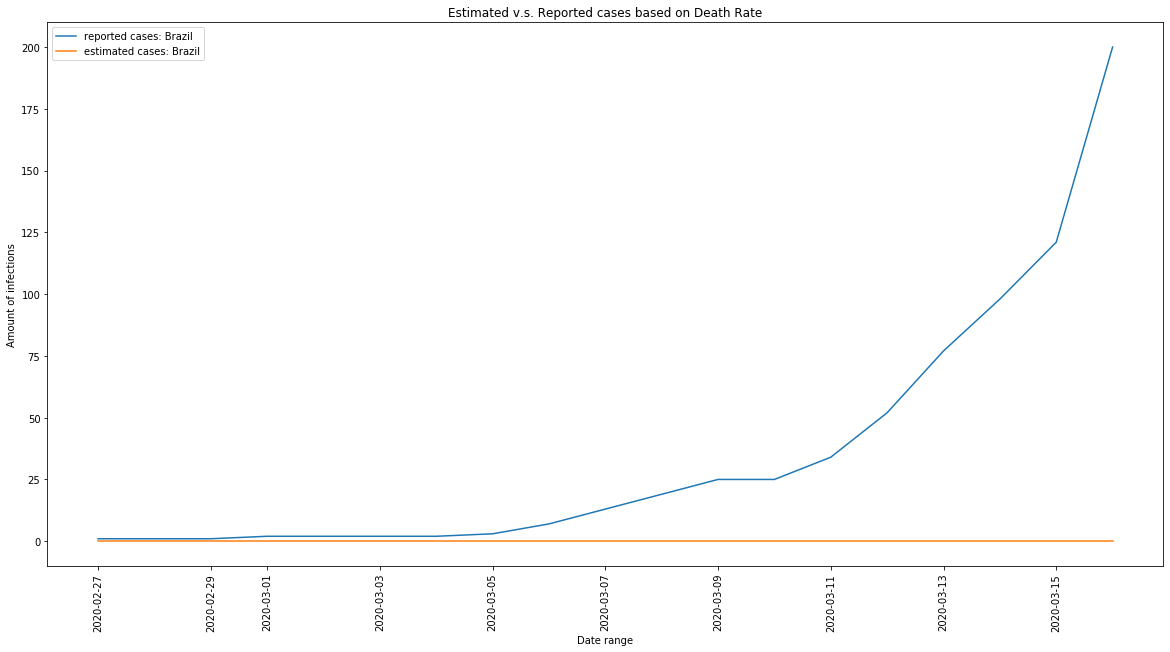

In [199]:
# plot dutch cases against Italian cases
country_list = ['Brazil']
plot_total_cases(country_list, 'Estimated v.s. Reported cases based on Death Rate', 10)

In [161]:
#lets make it more interactive with plotly
import plotly.graph_objects as go
traces_list = []
for item in more_then_c_list:
    x = full_set.loc[full_set['location'] == item]['date']

    trace = go.Scatter(x=x,
            y=full_set.loc[full_set['location'] == item]['total_cases'],
            name = item,
            )
    traces_list.append(trace)

Layout = go.Layout(xaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
                   yaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
                   xaxis_title="Days since outbreak",
                   yaxis_title="Amount of infected",
                    )

fig = go.Figure(data=traces_list, layout=Layout)
fig

# Lets look at new cases only
look at how the new cases are evolving over time, is there a logistic relation?

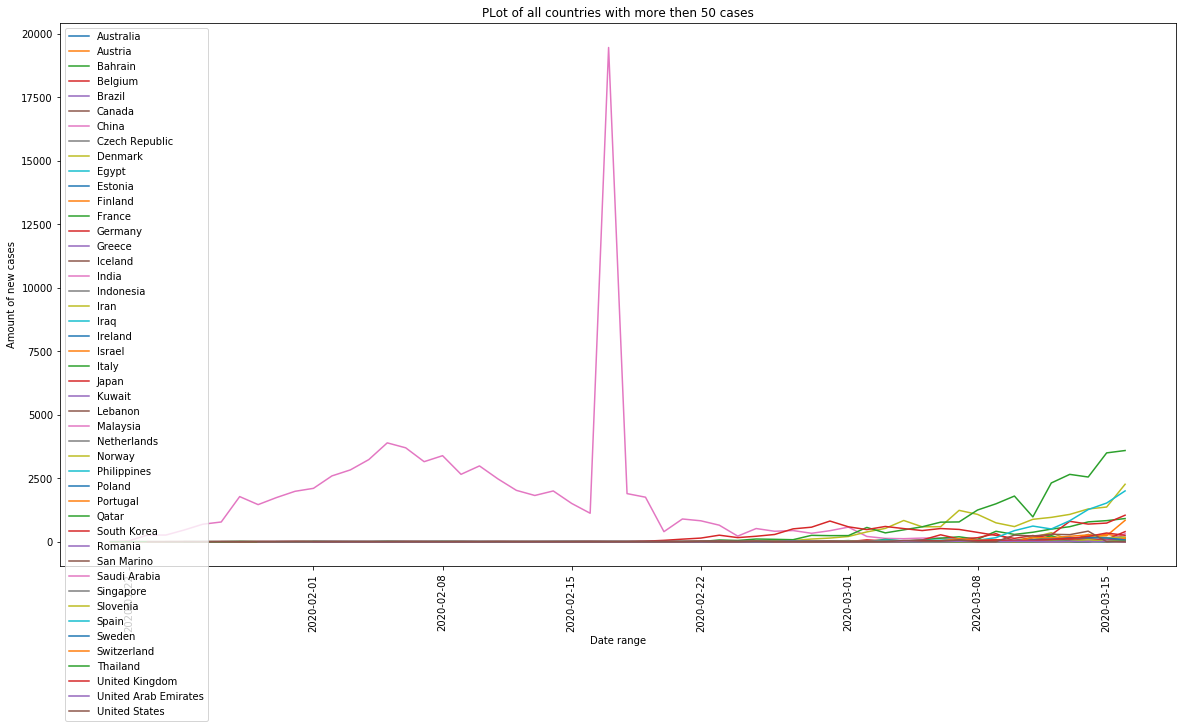

In [103]:
plot_new_cases(more_then_c_list, 'PLot of all countries with more then 50 cases')

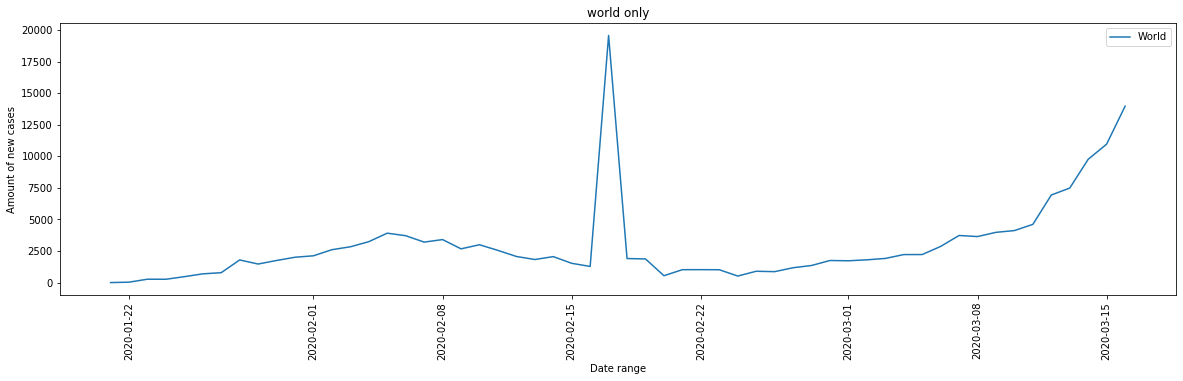

In [104]:
plot_new_cases(['World'], 'world only', height=5)

# look at Deaths per country
analysis on the amount of deaths per country

In [105]:
#First define a list with countries with reported deaths
c_with_deaths = list(set(full_set.loc[full_set['total_deaths'] > 1]['location']))
c_with_deaths.remove('International')
c_with_deaths.remove('World')
#c_with_deaths.remove('China')

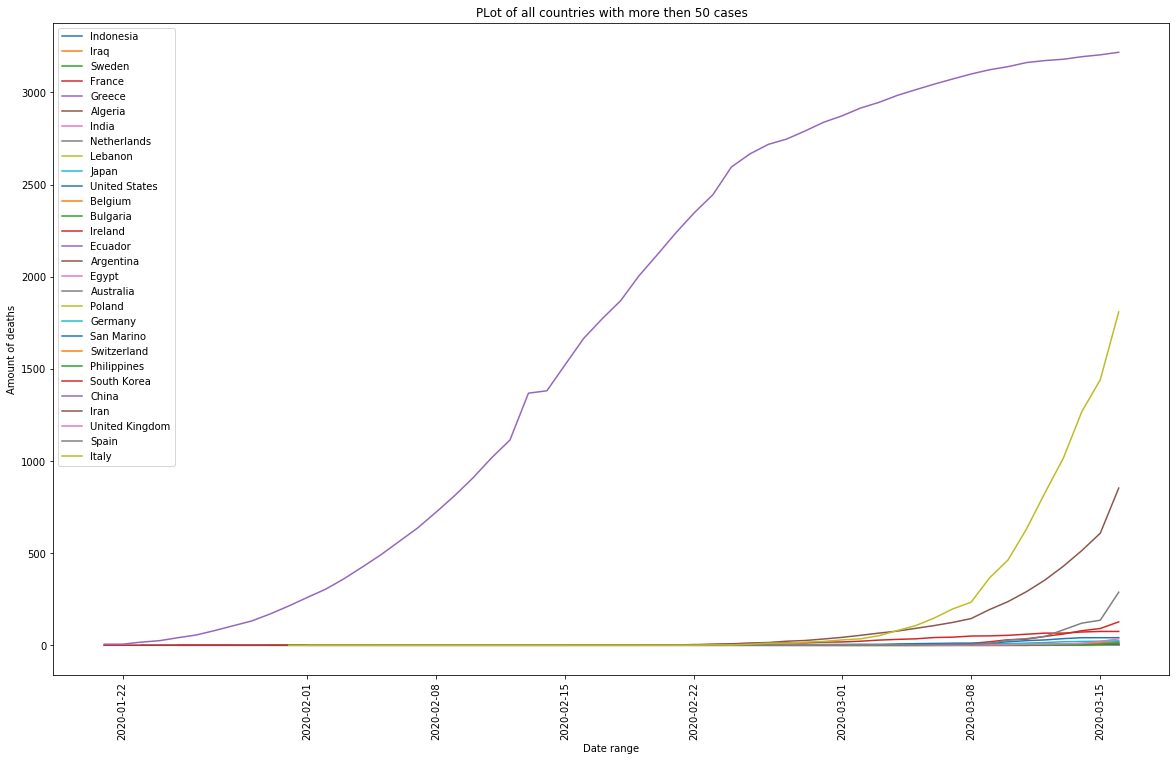

In [106]:
plot_death_cases(c_with_deaths, 'PLot of all countries with more then 50 cases', height = 12)

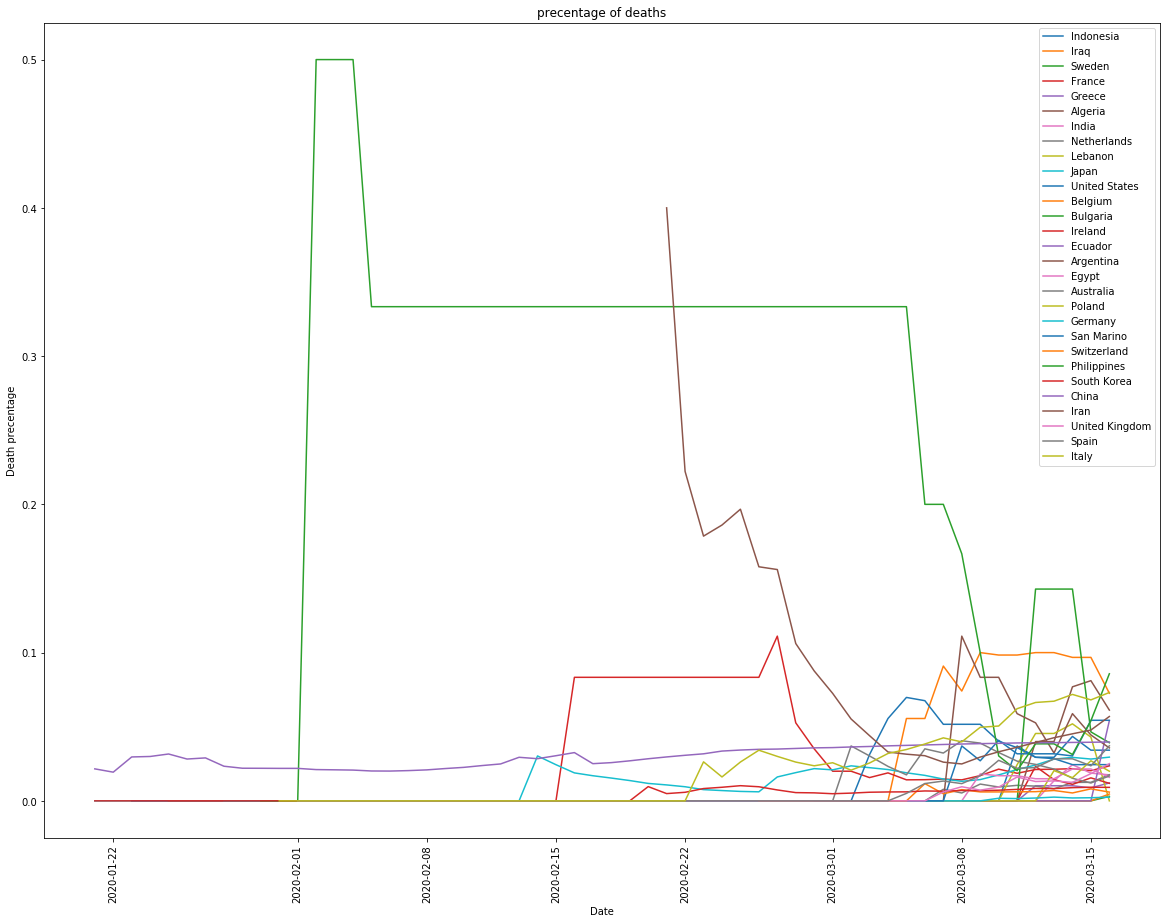

In [107]:
# deaths compared to infected (percentage)
plt.figure(figsize=(20,15))
stats = []
for country in c_with_deaths:
    plt.plot(death_rate(full_set, country)['date'], death_rate(full_set, country)['DR'], label=country)
    current =  death_rate(full_set, country)['DR'][-1:].values[0]
    mean_d = death_rate(full_set, country)['DR'].mean()
    median_d = death_rate(full_set, country)['DR'].median()
    max_d = death_rate(full_set, country)['DR'].max()
    min_d = death_rate(full_set, country)['DR'].min()
    std_d = death_rate(full_set, country)['DR'].std()
    stats.append([country, current, mean_d, max_d, min_d, std_d])
plt.ylabel("Death precentage")
plt.xlabel('Date')
plt.title('precentage of deaths')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

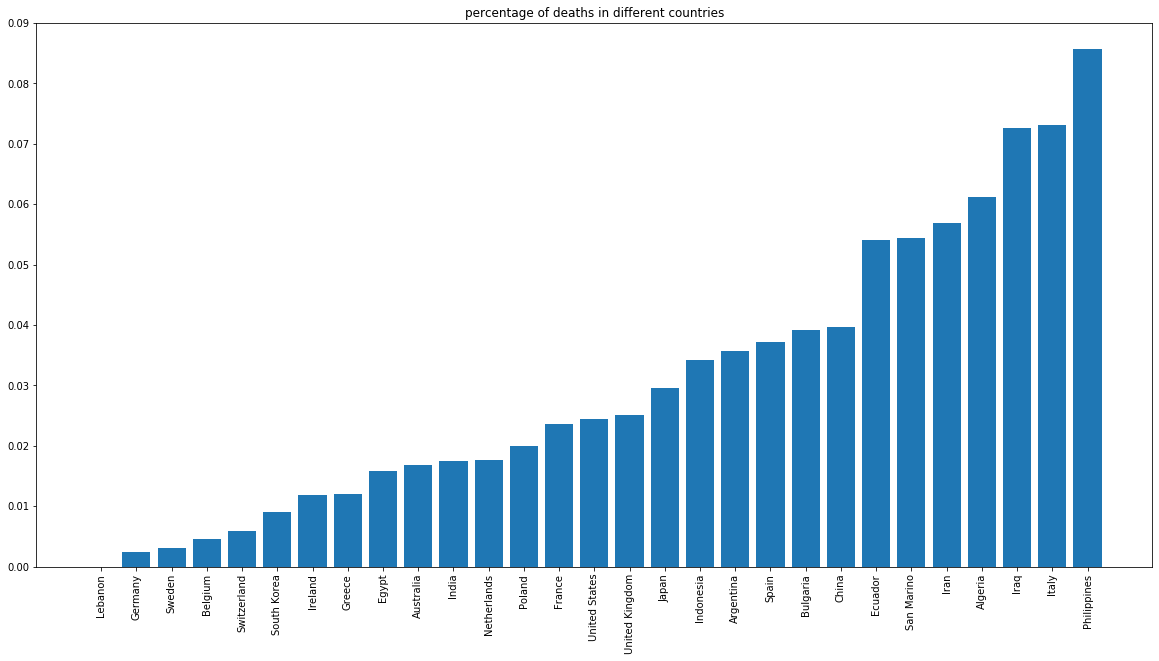

In [108]:
# Plot a Bar chart with the death rates
df = pd.DataFrame.from_records(stats)
#df.to_csv('test.csv')   #write to csv for further processing of the visualization.
df = df.sort_values(1)

# Plot a bar-chart with growth-rate
plt.figure(figsize=(20,10))
plt.bar(df[0], df[1], width=0.8)

plt.title('percentage of deaths in different countries')
plt.xticks(rotation = 90)
plt.show()

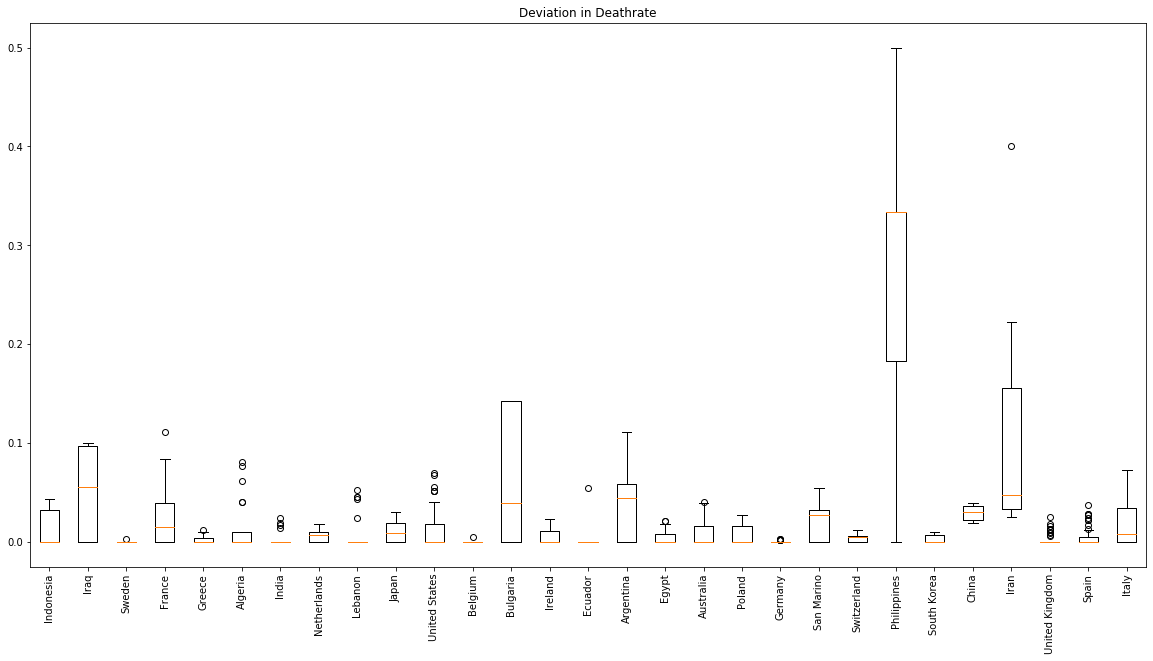

In [109]:
#fig = plt.figure(figsize=(20,10))
data = []
for country in c_with_deaths:
    data.append(death_rate(full_set, country)['DR'])
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.boxplot(data)
bp = ax1.set_xticklabels(c_with_deaths, rotation=90)
plt.title('Deviation in Deathrate')
plt.show()

# Forecast 
Done with a simple sigmoid function-linefit

based on data we predict:
03-17-2020 | amount of cases: 1787.115688387656 Known: 1705 Accuracy: 1.0481616940690064
03-18-2020 | amount of cases: 2430.7128144220665
03-19-2020 | amount of cases: 3224.9555679707587

R2 is : 6.959749789556778e+30


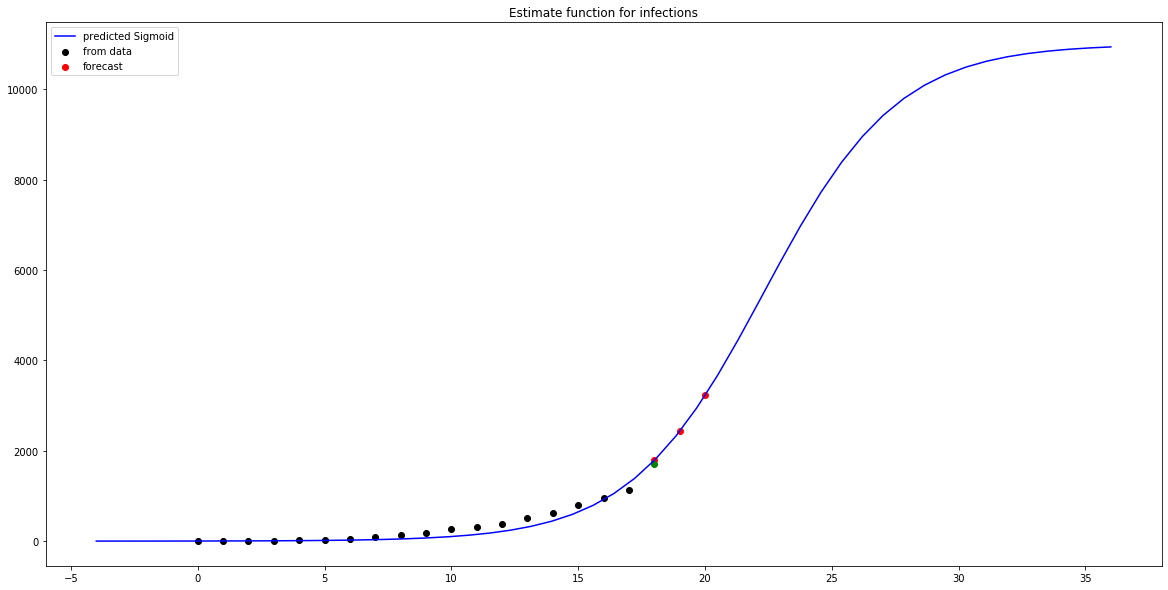

In [196]:
from sklearn import linear_model
import time
import datetime
import pylab as plt
date_format = "%Y-%m-%d"

#parameters to define
item = 'Netherlands'
start = 0
x_shift = 4
today = 1705
halfwaypoint = 5500


def sigmoid(x):
    return ((1 / (1 + np.exp(-0.38*x + 10)))) * 2 * halfwaypoint

mySamples = []
mySigmoid = []
shift = 500
# 
y1 = plt.linspace(-shift+shift,40)


xd = full_set.loc[full_set['location']== item]['date'][start:]
xd = [datetime.datetime.strptime(str(date)[:-9], date_format) for date in xd]
x = [(date-xd[0]).days for date in xd]

y = full_set.loc[full_set['location']== item]['total_cases'][start:]

x = np.array(x).reshape(-1, 1)
y = np.array(y)

# and plot the result
plt.figure(1, figsize=(20, 10))

#plot the data
plt.scatter(x, y, color='black', label='from data')

#plot estimations
plt.plot(y1-x_shift, sigmoid(y1), 'b', label='predicted Sigmoid')
pred_list = [int(x[-1])+1, int(x[-1])+2, int(x[-1])+3]
f_date = [(xd[-1] + datetime.timedelta(i)).__format__('%m-%d-%Y') for i in range(1,4)]
y_predlist = [sigmoid(x+x_shift) for x in pred_list]
plt.scatter(pred_list, y_predlist, color='red', label='forecast')
plt.scatter(int(x[-1])+1, today, color='green')

plt.title('Estimate function for infections')
plt.legend()


print("based on data we predict:")
print(f_date[0], '| amount of cases:', y_predlist[0], 'Known: {}'.format(today), 'Accuracy: {}'.format(y_predlist[0]/today))
print(f_date[1], '| amount of cases:', y_predlist[1])
print(f_date[2], '| amount of cases:', y_predlist[2])
print('')
print("R2 is :", sum([math.exp(y[i] - y_pred1[i]) for i in range(len(y))]))
plt.show()